In [1]:
import gzip
import sys
import time
import numpy as np
from sklearn.utils import shuffle
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
def get_data(sample_size, pathX, pathY):
    f = gzip.open(pathX, 'r')

    # read off unimportant bytes describing file protocol
    image_size = 28 * 28
    protocol_length = 16
    f.read(protocol_length)

    X = f.read(image_size * sample_size)
    X = np.frombuffer(X, dtype=np.uint8).astype(np.float32)
    X = X.reshape(sample_size, image_size)

    f = gzip.open(pathY, 'r')

    protocol_length = 8
    f.read(protocol_length)
    Y_temp = f.read(sample_size)
    Y_temp = np.frombuffer(Y_temp, dtype=np.uint8)

    Y = np.zeros([sample_size, 10], dtype='f')
    for sample in range(sample_size):
        Y[sample][Y_temp[sample]] = 1.0
    
    return [prep.scale(X), Y]

In [9]:
class Network:
    def __init__(self, layers):
        self.layers = layers
        self.w = []
        self.b = []
        for layer in range(1, len(layers)):
            self.w.append((2.0 * (np.random.randint(1e9, size=[layers[layer], layers[layer - 1]]) / 1e9)) - 1.0)
            self.b.append(((2.0 * (np.random.randint(1e9, size=[layers[layer]]) / 1e9)) - 1.0).reshape([layers[layer], 1]))

    def sigmoid(self, data):
        epsilon = 1e-8
        return 1.0 / (1.0 + np.exp(-data + epsilon))

    def sigmoid_derivative(self, data):
        temp = self.sigmoid(data)
        return temp * (1 - temp)

    def tanh(self, data):
        return np.tanh(data)
    
    def tanh_derivative(self, data):
        return 1 - np.tanh(data) ** 2

    def activation(self, data):
        return self.tanh(data)

    def activation_derivative(self, data):
        return self.tanh_derivative(data)

    def backPropFast(self, train_X, train_Y, eta, lambd, p_keep):
        m = len(train_X[0])

        gradients_w = [np.zeros([self.layers[layer], self.layers[layer - 1]], dtype='f') for layer in range(1, len(self.layers))]
        gradients_b = [np.zeros([self.layers[layer]], dtype='f') for layer in range(1, len(self.layers))]
        activations = [train_X]
        zs = [train_X]

        last_layer = len(self.layers) - 2

        for layer in range(len(self.layers) - 1):
            zs.append(np.dot(self.w[layer], activations[-1]) + self.b[layer])
            if layer == last_layer: activations.append(self.sigmoid(zs[-1]))
            else: activations.append(self.activation(zs[-1]))
            keeper = np.random.rand(activations[-1].shape[0], activations[-1].shape[1]) < p_keep[layer + 1]
            activations[-1] = np.multiply(activations[-1], keeper)

        delta_l = (activations[-1] - train_Y) * self.sigmoid_derivative(zs[-1])
        gradients_b[-1] = delta_l.sum(axis=1)
        gradients_w[-1] = np.dot(delta_l, np.transpose(activations[-2])) + lambd * self.w[-1] / float(m)

        for layer in range(len(self.layers) - 2, 0, -1):
            delta_l = np.dot(np.transpose(self.w[layer]), delta_l) * self.activation_derivative(zs[layer])
            gradients_b[layer - 1] += delta_l.sum(axis=1)
            gradients_w[layer - 1] += np.dot(delta_l, np.transpose(activations[layer - 1])) + lambd * self.w[layer - 1] / float(m)
        
        for layer in range(len(gradients_w)):
            self.w[layer] -= eta * gradients_w[layer] / float(m)
            self.b[layer] -= eta * gradients_b[layer].reshape([len(gradients_b[layer]), 1]) / float(m)

    def train(self, train_X, train_Y, batch_size, eta=1.0, lambd=0.0, p_keep=None):
        m = len(train_X[0]) #60000
        if not p_keep: p_keep = [1.0 for i in range(len(self.layers))]
        for batch in range(int(m / batch_size)):
            X = train_X[ : , batch * batch_size : (batch + 1) * batch_size]
            Y = train_Y[ : , batch * batch_size : (batch + 1) * batch_size]
            self.backPropFast(X, Y, eta, lambd, p_keep)

    def getOutputLayer(self, X, Y):
        last_layer = len(self.layers) - 2
        for layer in range(len(self.layers) - 1):
            if layer == last_layer: X = self.sigmoid(np.dot(self.w[layer], X) + self.b[layer].reshape([self.layers[layer + 1], 1]))
            else: X = self.activation(np.dot(self.w[layer], X) + self.b[layer].reshape([self.layers[layer + 1], 1]))
        return X

    def getAccuracy(self, X, Y):
        predictions = np.argmax(self.getOutputLayer(X, Y), 0)
        Y = np.argmax(Y, 0)
        return (predictions == Y).sum() / float(len(Y))

    def getLoss(self, X, Y):
        loss = np.sum(np.square(self.getOutputLayer(X, Y) - Y)) / float(Y.shape[1])
        return loss


In [12]:
train_size = 60000
test_size = 10000

"""MNIST DATASET"""
# train_X, train_Y = get_data(train_size, 'MNIST_Dataset/train-images-idx3-ubyte.gz', 'MNIST_Dataset/train-labels-idx1-ubyte.gz')
# test_X, test_Y = [np.transpose(a) for a in get_data(test_size, 'MNIST_Dataset/t10k-images-idx3-ubyte.gz', 'MNIST_Dataset/t10k-labels-idx1-ubyte.gz')]

"""FMNIST DATASET"""
train_X, train_Y = get_data(train_size, 'FMNIST_Dataset/train-images-idx3-ubyte.gz', 'FMNIST_Dataset/train-labels-idx1-ubyte.gz')
test_X, test_Y = [np.transpose(a) for a in get_data(test_size, 'FMNIST_Dataset/t10k-images-idx3-ubyte.gz', 'FMNIST_Dataset/t10k-labels-idx1-ubyte.gz')]


In [13]:
print(train_X.shape)
print(train_Y.shape)

print(test_X.shape)
print(test_Y.shape)

(60000, 784)
(60000, 10)
(784, 10000)
(10, 10000)


In [18]:
layers = [784, 32, 10]
batch_size = 32
eta = 5.0
epochs = 100
lambd = 25.0
decay_rate = 0.1
p_keep = [1.0, 1.0, 1.0]

network = Network(layers)

Epoch: 1 0.4826
Epoch: 2 0.6204
Epoch: 3 0.5164
Epoch: 4 0.668
Epoch: 5 0.6445
Epoch: 6 0.6371
Epoch: 7 0.7285
Epoch: 8 0.7416
Epoch: 9 0.755
Epoch: 10 0.7751
Epoch: 11 0.7776
Epoch: 12 0.7886
Epoch: 13 0.7848
Epoch: 14 0.7825
Epoch: 15 0.7854
Epoch: 16 0.7838
Epoch: 17 0.7845
Epoch: 18 0.7843
Epoch: 19 0.7843
Epoch: 20 0.7843
Epoch: 21 0.7843
Epoch: 22 0.7843
Epoch: 23 0.7843
Epoch: 24 0.7843
Epoch: 25 0.7843
Epoch: 26 0.7843
Epoch: 27 0.7843
Epoch: 28 0.7843
Epoch: 29 0.7843
Epoch: 30 0.7843
Epoch: 31 0.7843
Epoch: 32 0.7843
Epoch: 33 0.7843
Epoch: 34 0.7843
Epoch: 35 0.7843
Epoch: 36 0.7843
Epoch: 37 0.7843
Epoch: 38 0.7843
Epoch: 39 0.7843
Epoch: 40 0.7843
Epoch: 41 0.7843
Epoch: 42 0.7843
Epoch: 43 0.7843
Epoch: 44 0.7843
Epoch: 45 0.7843
Epoch: 46 0.7843
Epoch: 47 0.7843
Epoch: 48 0.7843
Epoch: 49 0.7843
Epoch: 50 0.7843
Epoch: 51 0.7843
Epoch: 52 0.7843
Epoch: 53 0.7843
Epoch: 54 0.7843
Epoch: 55 0.7843
Epoch: 56 0.7843
Epoch: 57 0.7843
Epoch: 58 0.7843
Epoch: 59 0.7843
Epoch: 6

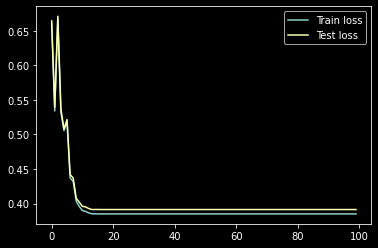

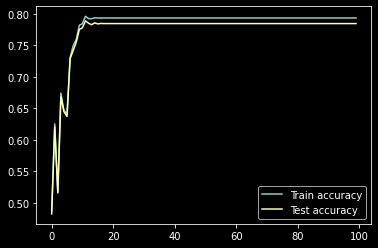

Final train accuracy: 0.7931833
Final test accuracy: 0.7843


In [19]:
train_accuracies = np.zeros([epochs], dtype='f')
test_accuracies = np.zeros([epochs], dtype='f')

train_losses = np.zeros([epochs], dtype='f')
test_losses = np.zeros([epochs], dtype='f')

for epoch in range(epochs):
    print("Epoch:", epoch + 1, end=" ")

    train_X, train_Y = shuffle(train_X, train_Y)
    start_time = time.perf_counter()
    network.train(np.transpose(train_X), np.transpose(train_Y), batch_size, eta, lambd, p_keep)
    eta = eta / (1 + decay_rate * epoch)

    train_losses[epoch] = network.getLoss(np.transpose(train_X), np.transpose(train_Y))
    test_losses[epoch] = network.getLoss(test_X, test_Y)

    train_accuracies[epoch] = network.getAccuracy(np.transpose(train_X), np.transpose(train_Y))
    test_accuracies[epoch] = network.getAccuracy(test_X, test_Y)

    print(test_accuracies[epoch])

    # print(f"Time taken in this epoch = {time.perf_counter() - start_time:0.1f} seconds")

plt.plot(np.arange(epochs), train_losses, label="Train loss")
plt.plot(np.arange(epochs), test_losses, label="Test loss")
plt.legend(loc="upper right")

plt.show()

plt.plot(np.arange(epochs), train_accuracies, label="Train accuracy")
plt.plot(np.arange(epochs), test_accuracies, label="Test accuracy")
plt.legend(loc="lower right")

plt.show()

print("Final train accuracy:", train_accuracies[-1])
print("Final test accuracy:", test_accuracies[-1])